### Replicating [Vit](https://arxiv.org/pdf/2010.11929.pdf)

Resources:
- https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/
- https://jalammar.github.io/illustrated-transformer/
- https://www.youtube.com/watch?v=dichIcUZfOw
- https://www.youtube.com/watch?v=mMa2PmYJlCo
- https://www.youtube.com/watch?v=gJ9kaJsE78k
- https://www.youtube.com/watch?v=cbYxHkgkSVs&t=800s

In [1]:
import torch
import torchvision
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 1.12.1+cu113
torchvision version: 0.13.1+cu113


In [2]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
try:
    from services.utils import download_data
except:
    print("[INFO] Can't find custom scripts, downloading...")
    !git clone https://github.com/A1DS19/food-vision.git
    !mv ./food-vision/* ./
    !rm -rf ./food-vision
    !rm cell_mode_code.ipynb
    !rm README.md
    !rm -rf models

[INFO] Can't find custom scripts, downloading...
Cloning into 'food-vision'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 125 (delta 71), reused 88 (delta 34), pack-reused 0
Receiving objects: 100% (125/125), 156.89 KiB | 13.07 MiB/s, done.
Resolving deltas: 100% (71/71), done.
rm: cannot remove 'cell_mode_code.ipynb': No such file or directory


In [5]:
from services.utils import download_data

download_data(data_url='https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip',
              image_folder='pizza_steak_sushi')

data directory does not exists, creating one...
data/pizza_steak_sushi directory does not exists, creating one...
Downloading, dataset...
Dataset downloaded in data/pizza_steak_sushi.zip
Unzipping dataset...
Dataset unzipped in data/pizza_steak_sushi.zip


In [6]:
from pathlib import Path

data_path = Path('./data/pizza_steak_sushi/')
train_path = data_path / 'train/'
test_path = data_path / 'test'

train_path, test_path

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [7]:
IMG_RESIZE = (224, 224)
BATCH_SIZE = 32

In [8]:
from services.data_setup import SetupData
from torchvision import transforms

setup_data = SetupData(train_dir=train_path,
                       test_dir=test_path,
                       resize_imgs=IMG_RESIZE)

train_dataloader, test_dataloader, class_names = setup_data.create_dataloaders()

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f2c0a389110>,
 ['pizza', 'steak', 'sushi'])

In [9]:
imgs_batch, labels_batch = next(iter(train_dataloader))

imgs_batch.shape, labels_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

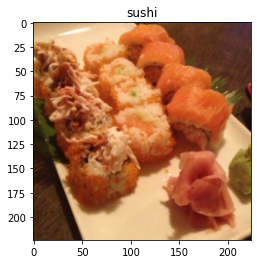

In [10]:
import matplotlib.pyplot as plt

img = imgs_batch[0]
label = labels_batch[0]

plt.imshow(img.permute(1, 2, 0));
plt.title(class_names[label]);

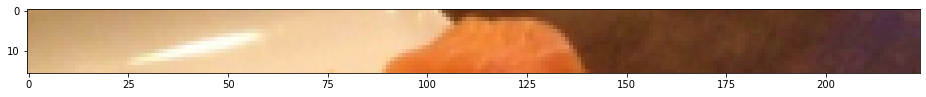

In [11]:
img_permuted = img.permute(1, 2, 0)
path_size = 16
plt.figure(figsize=(path_size, path_size));
plt.imshow(img_permuted[:path_size, :, :]);

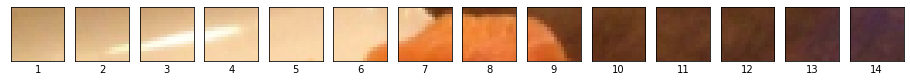

In [12]:
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, 'Image size must be divisable by patch size'

fig, axis = plt.subplots(nrows=1,
                         ncols=img_size // patch_size,
                         sharex=True,
                         sharey=True,
                         figsize=(patch_size, patch_size))

for i, patch in enumerate(range(0, img_size, patch_size)):
    axis[i].imshow(img_permuted[:patch_size, patch:patch+patch_size, :])
    axis[i].set_xlabel(i+1)
    axis[i].set_xticks([])
    axis[i].set_yticks([])

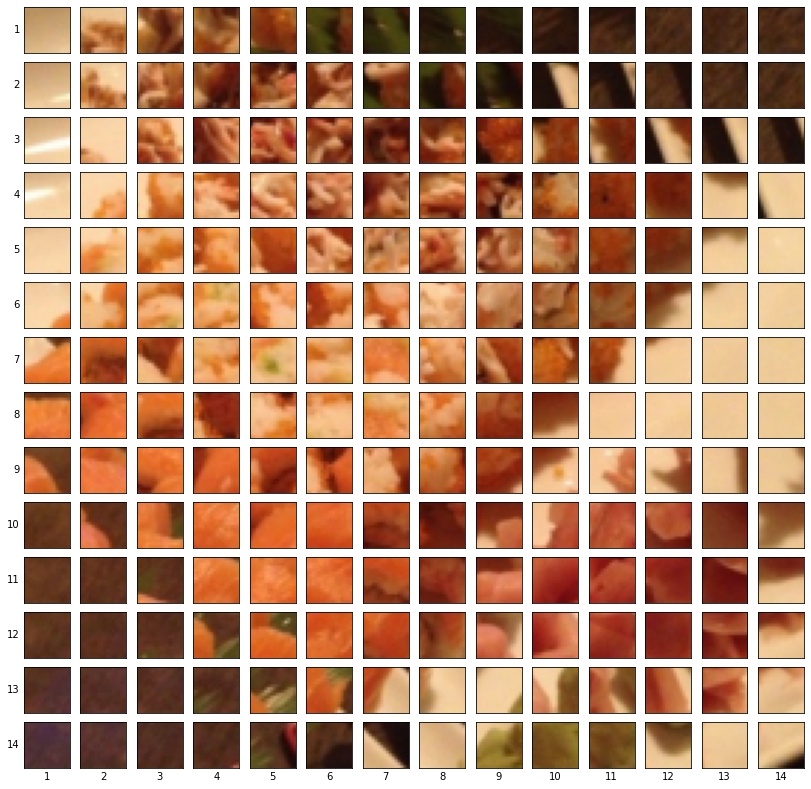

In [13]:
import numpy as np

img_permuted = np.array(img_permuted)

fig, axis = plt.subplots(nrows=img_size // patch_size,
                         ncols=img_size // patch_size,
                         sharex=True,
                         sharey=True,
                         figsize=(num_patches, num_patches))

for i, x_patch in enumerate(range(0, img_size, patch_size)):
    for j, y_patch in enumerate(range(0, img_size, patch_size)):
        axis[i, j].imshow(img_permuted[y_patch:y_patch+patch_size,
                                       x_patch:x_patch+patch_size,
                                       :])
        axis[i, j].set_ylabel(i+1,
                              rotation='horizontal',
                              horizontalalignment='right',
                              verticalalignment='center')
        axis[i, j].set_xlabel(j+1)
        axis[i, j].set_xticks([])
        axis[i, j].set_yticks([])
        axis[i, j].label_outer()

In [14]:
width = 224
heigth = 224
color_channels = 3
patch_size = 16
number_of_patches = int((width * heigth) / patch_size**2)
embedding_input_shape = (heigth, width, color_channels)
embedding_output_shape = (number_of_patches, patch_size**2 * color_channels)

number_of_patches, embedding_input_shape, embedding_output_shape

(196, (224, 224, 3), (196, 768))

In [15]:
import torch.nn as nn

conv2d = nn.Conv2d(in_channels=color_channels,
                   out_channels=embedding_output_shape[1],
                   stride=patch_size,
                   kernel_size=patch_size)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

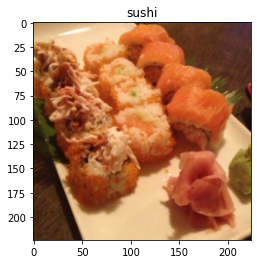

In [16]:
plt.imshow(img.permute(1, 2, 0));
plt.title(class_names[label]);

In [17]:
img_out_conv = conv2d(img.unsqueeze(0))
img_out_conv.shape

torch.Size([1, 768, 14, 14])

Showing random convolutional feature maps from indexes: [219, 416, 455, 194, 425]


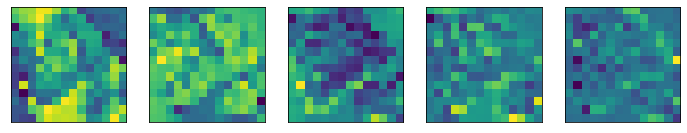

In [18]:
import random
random_indexes = random.sample(range(0, 768), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

for i, idx in enumerate(random_indexes):
    image_conv_feature_map = img_out_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

### Creating patch embedding layer

In [19]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                 img_size:int = 224,
                 in_channels:int = 3, # color channels
                 patch_size:int = 16,
                 stride:int = 16,
                 kernel_size:int = 16):
        super().__init__()
        
        self.number_of_patches = int((img_size * img_size) / patch_size**2)
        self.embedding_input_shape = (img_size, img_size, in_channels)
        self.embedding_output_shape = (self.number_of_patches, patch_size**2 * in_channels)
        
        self.conv2d = nn.Conv2d(in_channels=in_channels,
                                out_channels=self.embedding_output_shape[-1], #768
                                stride=stride,
                                kernel_size=kernel_size)
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
        
    
    def forward(self, x):
        img_resolution = x.shape[-1]
        assert img_resolution & patch_size == 0, f'Input image size must be divisible by the patch size'
        x = self.conv2d(x)
        x = self.flatten(x)
        x = x.permute(0, 2, 1)        
        return x

In [20]:
embedd_image = PatchEmbedding()

img_out_conv_flattened = embedd_image(img.unsqueeze(0))
img_out_conv_flattened.shape, img_out_conv_flattened

(torch.Size([1, 196, 768]),
 tensor([[[-0.2030,  0.1372,  0.1462,  ...,  0.6220,  0.3791, -0.2886],
          [-0.1911,  0.1723,  0.1672,  ...,  0.6835,  0.4133, -0.2837],
          [-0.1779,  0.2077,  0.1275,  ...,  0.8479,  0.5146, -0.3375],
          ...,
          [-0.1627,  0.0042,  0.2267,  ...,  0.7547,  0.5367, -0.3260],
          [-0.2141,  0.0931,  0.1824,  ...,  0.6659,  0.3742, -0.3011],
          [-0.0721,  0.2103,  0.1312,  ...,  0.5243,  0.2738, -0.2378]]],
        grad_fn=<PermuteBackward0>))

Text(0.5, 1.0, 'Flattened feature map: torch.Size([1, 196])')

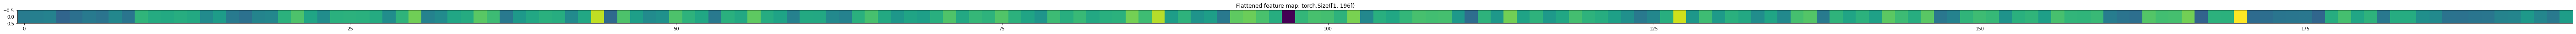

In [21]:
single_flattened_embedding = img_out_conv_flattened[:, :, 0]
plt.figure(figsize=(100, 100))
plt.imshow(single_flattened_embedding.detach().numpy())
plt.title(f'Flattened feature map: {single_flattened_embedding.shape}')

### Creating class token embedding

In [22]:
patch_embedded_img = img_out_conv_flattened
patch_embedded_img, patch_embedded_img.shape

(tensor([[[-0.2030,  0.1372,  0.1462,  ...,  0.6220,  0.3791, -0.2886],
          [-0.1911,  0.1723,  0.1672,  ...,  0.6835,  0.4133, -0.2837],
          [-0.1779,  0.2077,  0.1275,  ...,  0.8479,  0.5146, -0.3375],
          ...,
          [-0.1627,  0.0042,  0.2267,  ...,  0.7547,  0.5367, -0.3260],
          [-0.2141,  0.0931,  0.1824,  ...,  0.6659,  0.3742, -0.3011],
          [-0.0721,  0.2103,  0.1312,  ...,  0.5243,  0.2738, -0.2378]]],
        grad_fn=<PermuteBackward0>), torch.Size([1, 196, 768]))

In [23]:
batch_size = patch_embedded_img.shape[0]
embedding_dimension = patch_embedded_img.shape[-1]

batch_size, embedding_dimension

(1, 768)

In [24]:
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension))
class_token.shape

torch.Size([1, 1, 768])

In [25]:
# -> (batch_size, class_token + number_of_patches, embedding_dim)
patch_embedded_img_with_class_embedding = torch.cat((class_token, patch_embedded_img), dim=1)

patch_embedded_img_with_class_embedding, patch_embedded_img_with_class_embedding.shape, patch_embedded_img.shape
# notice the new shape on the number_of_patches
# from 196 -> 197 due to extra class_token

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.2030,  0.1372,  0.1462,  ...,  0.6220,  0.3791, -0.2886],
          [-0.1911,  0.1723,  0.1672,  ...,  0.6835,  0.4133, -0.2837],
          ...,
          [-0.1627,  0.0042,  0.2267,  ...,  0.7547,  0.5367, -0.3260],
          [-0.2141,  0.0931,  0.1824,  ...,  0.6659,  0.3742, -0.3011],
          [-0.0721,  0.2103,  0.1312,  ...,  0.5243,  0.2738, -0.2378]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]),
 torch.Size([1, 196, 768]))

In [26]:
batch_size, embedding_dimension

(1, 768)

In [27]:
class ClassEmbedding(nn.Module):
    def __init__(self,
                 embedding_dim:int=768):
        super().__init__()
        self.class_token = nn.Parameter(torch.randn(1, 1, embedding_dim))
    
    def forward(self, x):
        batch_size = x.shape[0]
        class_token_expanded = self.class_token.expand(batch_size, -1, -1)
        x = torch.cat((class_token_expanded, x), dim=1)
        return x

In [28]:
class_embedding = ClassEmbedding()
class_embedded_img_with_patch_embedding = class_embedding(patch_embedded_img)

print(class_embedded_img_with_patch_embedding)
print(f'Old img shape + class dim: {patch_embedded_img.shape}')
print(f'New img shape + class dim: {class_embedded_img_with_patch_embedding.shape}')

tensor([[[-0.0416, -0.5844,  1.2924,  ...,  1.1261,  1.1534,  1.1003],
         [-0.2030,  0.1372,  0.1462,  ...,  0.6220,  0.3791, -0.2886],
         [-0.1911,  0.1723,  0.1672,  ...,  0.6835,  0.4133, -0.2837],
         ...,
         [-0.1627,  0.0042,  0.2267,  ...,  0.7547,  0.5367, -0.3260],
         [-0.2141,  0.0931,  0.1824,  ...,  0.6659,  0.3742, -0.3011],
         [-0.0721,  0.2103,  0.1312,  ...,  0.5243,  0.2738, -0.2378]]],
       grad_fn=<CatBackward0>)
Old img shape + class dim: torch.Size([1, 196, 768])
New img shape + class dim: torch.Size([1, 197, 768])


### Creating position embeddings

In [29]:
patch_embedded_img_with_class_embedding, patch_embedded_img_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.2030,  0.1372,  0.1462,  ...,  0.6220,  0.3791, -0.2886],
          [-0.1911,  0.1723,  0.1672,  ...,  0.6835,  0.4133, -0.2837],
          ...,
          [-0.1627,  0.0042,  0.2267,  ...,  0.7547,  0.5367, -0.3260],
          [-0.2141,  0.0931,  0.1824,  ...,  0.6659,  0.3742, -0.3011],
          [-0.0721,  0.2103,  0.1312,  ...,  0.5243,  0.2738, -0.2378]]],
        grad_fn=<CatBackward0>), torch.Size([1, 197, 768]))

In [30]:
# calculate number of patches
num_patches = int((heigth * width) / patch_size**2)

# get embedding dim
embedding_dimension = patch_embedded_img_with_class_embedding.shape[-1]

# learnable 1d pos embedding
position_embedding = nn.Parameter(torch.ones((1, num_patches + 1, embedding_dimension)))
                                  
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [31]:
# add pos embedding to the patch and class token embedding
patch_position_embedding = patch_embedded_img_with_class_embedding + position_embedding
patch_position_embedding, patch_position_embedding.shape

(tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
          [0.7970, 1.1372, 1.1462,  ..., 1.6220, 1.3791, 0.7114],
          [0.8089, 1.1723, 1.1672,  ..., 1.6835, 1.4133, 0.7163],
          ...,
          [0.8373, 1.0042, 1.2267,  ..., 1.7547, 1.5367, 0.6740],
          [0.7859, 1.0931, 1.1824,  ..., 1.6659, 1.3742, 0.6989],
          [0.9279, 1.2103, 1.1312,  ..., 1.5243, 1.2738, 0.7622]]],
        grad_fn=<AddBackward0>), torch.Size([1, 197, 768]))

In [32]:
class PositionEmbedding(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 img_size:int=224,
                 dropout=0.1):
        super().__init__()
        self.num_patches = int((img_size * img_size) / patch_size**2)
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, embedding_dim))
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        x = x + self.pos_embedding
        x = self.dropout(x)
        return x

In [33]:
position_embedding = PositionEmbedding(embedding_dim=embedding_dimension,
                                       img_size=224)

pos_embedded_img_with_class_embedding_with_patch_embedding = position_embedding(class_embedded_img_with_patch_embedding)
pos_embedded_img_with_class_embedding_with_patch_embedding, pos_embedded_img_with_class_embedding_with_patch_embedding.shape

(tensor([[[-1.2056, -0.4683,  1.1814,  ...,  1.1095,  0.2978, -0.7858],
          [ 1.3818,  1.6690, -0.2366,  ...,  1.1019,  1.3117, -0.8279],
          [ 0.3854,  0.9872, -0.7291,  ...,  0.1625,  0.7352, -1.2646],
          ...,
          [-1.5011, -0.4017,  0.2064,  ...,  0.1595,  1.4872, -0.9467],
          [ 1.0503, -1.5189, -0.7675,  ...,  1.6366,  0.1283,  0.4776],
          [ 0.5617,  0.1149,  0.2715,  ..., -0.1207, -0.6047, -0.8701]]],
        grad_fn=<MulBackward0>), torch.Size([1, 197, 768]))

### Preprocess input

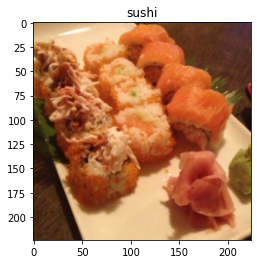

In [34]:
plt.imshow(img.permute(1, 2, 0));
plt.title(class_names[label]);

In [35]:
patch_embedding = PatchEmbedding()
class_embedding = ClassEmbedding()
position_embedding = PositionEmbedding()

In [36]:
patch_embedded_img = patch_embedding(img.unsqueeze(dim=0))
class_embedded_img = class_embedding(patch_embedded_img)
position_embedded_img = position_embedding(class_embedded_img)

In [37]:
patch_embedded_img.shape, class_embedded_img.shape, position_embedded_img.shape

(torch.Size([1, 196, 768]),
 torch.Size([1, 197, 768]),
 torch.Size([1, 197, 768]))

In [38]:
patch_embedded_img

tensor([[[ 0.0263,  0.4624, -0.0570,  ..., -0.3201, -0.0603,  0.2974],
         [ 0.0291,  0.5080, -0.0633,  ..., -0.3361, -0.0908,  0.3028],
         [ 0.0078,  0.5915, -0.0656,  ..., -0.3537, -0.1152,  0.3982],
         ...,
         [ 0.0595,  0.4296, -0.1040,  ..., -0.3627, -0.0171,  0.4166],
         [ 0.0299,  0.5154, -0.0120,  ..., -0.2943, -0.0813,  0.3006],
         [-0.0690,  0.4276,  0.0959,  ..., -0.2900, -0.2277,  0.0158]]],
       grad_fn=<PermuteBackward0>)

In [39]:
class_embedded_img

tensor([[[-0.1498,  0.7258,  0.0387,  ..., -0.7182, -1.0873, -0.0764],
         [ 0.0263,  0.4624, -0.0570,  ..., -0.3201, -0.0603,  0.2974],
         [ 0.0291,  0.5080, -0.0633,  ..., -0.3361, -0.0908,  0.3028],
         ...,
         [ 0.0595,  0.4296, -0.1040,  ..., -0.3627, -0.0171,  0.4166],
         [ 0.0299,  0.5154, -0.0120,  ..., -0.2943, -0.0813,  0.3006],
         [-0.0690,  0.4276,  0.0959,  ..., -0.2900, -0.2277,  0.0158]]],
       grad_fn=<CatBackward0>)

In [40]:
position_embedded_img

tensor([[[ 2.3551, -0.6234, -0.5652,  ..., -2.5815, -2.0053,  0.9214],
         [ 1.9078,  1.0738, -1.6343,  ...,  0.6182,  0.8990,  1.6341],
         [-0.9411,  0.3538, -0.9335,  ..., -0.0000,  0.5276,  2.1859],
         ...,
         [-0.0000,  0.0000, -2.6640,  ..., -0.4896,  2.3744,  0.3963],
         [ 0.6959, -0.5304, -0.0000,  ...,  2.1682,  0.2566, -0.2792],
         [-0.4350, -2.4214,  0.0000,  ...,  0.0000,  2.5348,  0.7129]]],
       grad_fn=<MulBackward0>)

### Multihead self attention (MSA block)

In [41]:
class MultiHeadSelfAttentionBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int = 768, # 768 embeddings dimension
                 num_heads:int = 12, # number of heads for MSA block according to paper for ViT base 12
                 attention_dropout:float = 0): 
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.layer_MSA = nn.MultiheadAttention(embed_dim=embedding_dim,
                                               num_heads=num_heads,
                                               dropout=attention_dropout,
                                               batch_first=True) # input and output tensors are in (batch, seq, feature) -> (batch, num_patches, embedding_dim)
    
    def forward(self, x):
        x = self.layer_norm(x)
        attention_output, _ = self.layer_MSA(query=x,
                                             key=x,
                                             value=x, 
                                             need_weights=False) # takes q, k, v all are versions of the same vector
        return attention_output

In [42]:
attention_block = MultiHeadSelfAttentionBlock()
res_attention = attention_block(position_embedded_img)
res_attention, res_attention.shape

(tensor([[[-0.0604,  0.0827,  0.1133,  ..., -0.0096,  0.1316,  0.0735],
          [-0.0688,  0.0822,  0.1139,  ..., -0.0009,  0.0980,  0.0891],
          [-0.0656,  0.0842,  0.1326,  ...,  0.0108,  0.0956,  0.0656],
          ...,
          [-0.0775,  0.0743,  0.1188,  ..., -0.0328,  0.0638,  0.0685],
          [-0.0754,  0.0823,  0.1266,  ..., -0.0481,  0.1006,  0.0717],
          [-0.0544,  0.0806,  0.1266,  ..., -0.0269,  0.1146,  0.0376]]],
        grad_fn=<TransposeBackward0>), torch.Size([1, 197, 768]))

### MLP block

In [43]:
class MultiLayerPerceptronBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int = 768,
                 MLP_size:int = 3072,
                 MLP_dropout:int = 0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        # expand features with larger Linear output and the contract them with second Linear layer output
        self.MLP = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=MLP_size),
            nn.GELU(),
            nn.Dropout(p=MLP_dropout),
            nn.Linear(in_features=MLP_size,
                      out_features=embedding_dim),
            nn.Dropout(p=MLP_dropout)
        )
        
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.MLP(x)
        return x

In [44]:
mlp_block = MultiLayerPerceptronBlock()
mlp_res = mlp_block(res_attention)
mlp_res, mlp_res.shape

(tensor([[[-0.0830,  0.5136, -0.2051,  ..., -0.6882, -0.0913,  0.1308],
          [ 0.0126,  0.3966,  0.0056,  ..., -0.8521,  0.0000,  0.1914],
          [-0.0083,  0.3946, -0.2766,  ..., -0.5551, -0.1419,  0.2292],
          ...,
          [-0.0264,  0.3313, -0.0750,  ..., -0.5872,  0.0176,  0.0967],
          [-0.1293,  0.5519, -0.2252,  ..., -0.6905, -0.0000,  0.1718],
          [-0.0715,  0.3025, -0.0000,  ..., -0.5593, -0.2104,  0.0125]]],
        grad_fn=<MulBackward0>), torch.Size([1, 197, 768]))

### Transformer encoder

In [45]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int = 768,
                 num_heads:int = 12,
                 attention_dropout:float = 0,
                 MLP_size:int = 3072,
                 MLP_dropout:int = 0.1):
        super().__init__()
        self.attention_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                           num_heads=num_heads,
                                                           attention_dropout=attention_dropout)
        
        self.MLP_block = MultiLayerPerceptronBlock(embedding_dim=embedding_dim,
                                                   MLP_size=MLP_size,
                                                   MLP_dropout=MLP_dropout)
    
    def forward(self, x):
        input_ = x
        
        x = self.attention_block(x)
        x += input_
        
        x = self.MLP_block(x)
        x += input_
        
        return x

In [46]:
from torchinfo import summary

encoder = TransformerEncoderBlock()

summary(model=encoder,
        input_size=(1, 197, 768), # (batch, num_patches, embedding_dim)
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names']
       )

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)       [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (attention_block)         [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (layer_MSA)                   --                   [1, 197, 768]        2,362,368            True
├─MultiLayerPerceptronBlock (MLP_block)                 [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (MLP)                                 [1, 197, 768]        [1, 197, 768]        --                   True
│  

### Transformer encoder layer with pytorch
https://pytorch.org/docs/stable/nn.html#transformer-layers

In [47]:
torch_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                           nhead=12,
                                           dim_feedforward=3072,
                                           dropout=0.1,
                                           activation=nn.GELU(),
                                           batch_first=True,
                                           norm_first=True)
torch_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (activation): GELU(approximate=none)
)

In [48]:
summary(model=torch_encoder_layer,
        input_size=(1, 197, 768), # (batch, num_patches, embedding_dim)
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names']
       )

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─GELU (activation)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Dropout (dropout)                            

### Entire transformer

In [49]:
patch_size = 16
number_of_patches = int((width * heigth) / patch_size**2)
embedding_input_shape = (heigth, width, color_channels)
embedding_output_shape = (number_of_patches, patch_size**2 * color_channels)

In [50]:
class ViTransformer(nn.Module):
    def __init__(self,
                 img_size:int = 224,
                 patch_size:int = 16,
                 in_channels:int = 3,
                 num_classes:int = 1000,
                 num_transformer_layers:int = 12,
                 embedding_dim: int = 768,
                 num_heads: int = 12,
                 attention_dropout: float = 0,
                 MLP_size: int = 3072,
                 MLP_dropout: int = 0.1,
                 pos_embedding_dropout:int = 0.1):
        super().__init__()
        assert img_size % patch_size == 0, f'Image size must be divisible by patch size, currently: {img_size % patch_size}'
        
        self.patch_embedding = PatchEmbedding(img_size=img_size,
                                              in_channels=in_channels,
                                              patch_size=patch_size,
                                              stride=patch_size,
                                              kernel_size=patch_size)
        
        self.class_embedding = ClassEmbedding(embedding_dim=embedding_dim)
        
        self.position_embedding = PositionEmbedding(embedding_dim=embedding_dim,
                                                   img_size=img_size,
                                                   dropout=pos_embedding_dropout)
        
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                           num_heads=num_heads,
                                                                           attention_dropout=attention_dropout,
                                                                           MLP_size=MLP_size,
                                                                           MLP_dropout=MLP_dropout) for _ in range(num_transformer_layers)])
        
        self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape=embedding_dim),
                                        nn.Linear(in_features=embedding_dim,
                                                  out_features=num_classes))
    
    def preprocess_input(self, x):
        x = self.patch_embedding(x)
        x = self.class_embedding(x)
        x = self.position_embedding(x)
        return x
    
    def forward(self, x):
        x = self.preprocess_input(x)
        x = self.transformer_encoder(x)
        x = self.classifier(x[:, 0])
        return x

In [51]:
vit = ViTransformer(num_classes=3)

In [52]:
random_img = torch.randn(1, 3, 224, 224)
res = vit(random_img)
res

tensor([[0.4233, 0.3248, 0.3396]], grad_fn=<AddmmBackward0>)

In [53]:
summary(model=ViTransformer(num_classes=3),
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, H, W)
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names']
       )

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
ViTransformer (ViTransformer)                                     [1, 3, 224, 224]     [1, 3]               --                   True
├─PatchEmbedding (patch_embedding)                                [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (conv2d)                                            [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                          [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─ClassEmbedding (class_embedding)                                [1, 196, 768]        [1, 197, 768]        768                  True
├─PositionEmbedding (position_embedding)                          [1, 197, 768]        [1, 197, 768]        151,296              True
│    └─Dropout (dropout)                                   

### Train ViT

In [54]:
!nvidia-smi

Sun Nov 20 06:15:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   23C    P0    48W / 400W |   2216MiB / 40536MiB |      5%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [55]:
model = ViTransformer(num_classes=3)

In [56]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             weight_decay=0.1,
                             lr=1e-3)

In [57]:
from services.utils import create_summary_writer

writer = create_summary_writer(experiment_name='VIT',
                               extra='5_EPOCHS',
                               model_name='VIT')

[INFO] Created SummaryWriter saving to runs/2022-11-20/VIT/VIT/5_EPOCHS


In [58]:
from services.engine import TrainTestStep

epochs = 10

train_setup = TrainTestStep(model=model,
                            train_dataloader=train_dataloader,
                            test_dataloader=test_dataloader,
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            epochs=epochs,
                            device=device)

res_cutom_vit = train_setup.train_model()

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.7101 | train_acc: 0.3008 | test_loss: 1.2936 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.9529 | train_acc: 0.2578 | test_loss: 1.4581 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.2578 | train_acc: 0.4141 | test_loss: 1.7299 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.2724 | train_acc: 0.2656 | test_loss: 1.4601 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1910 | train_acc: 0.4180 | test_loss: 2.0120 | test_acc: 0.1979
Epoch: 6 | train_loss: 1.2809 | train_acc: 0.2969 | test_loss: 1.0053 | test_acc: 0.5417
Epoch: 7 | train_loss: 1.3343 | train_acc: 0.2969 | test_loss: 1.0681 | test_acc: 0.5417
Epoch: 8 | train_loss: 1.1818 | train_acc: 0.2891 | test_loss: 1.0944 | test_acc: 0.5417
Epoch: 9 | train_loss: 1.2392 | train_acc: 0.2930 | test_loss: 1.2972 | test_acc: 0.2604
Epoch: 10 | train_loss: 1.3695 | train_acc: 0.2891 | test_loss: 1.1999 | test_acc: 0.1979
Model took 39.25 seconds to train.


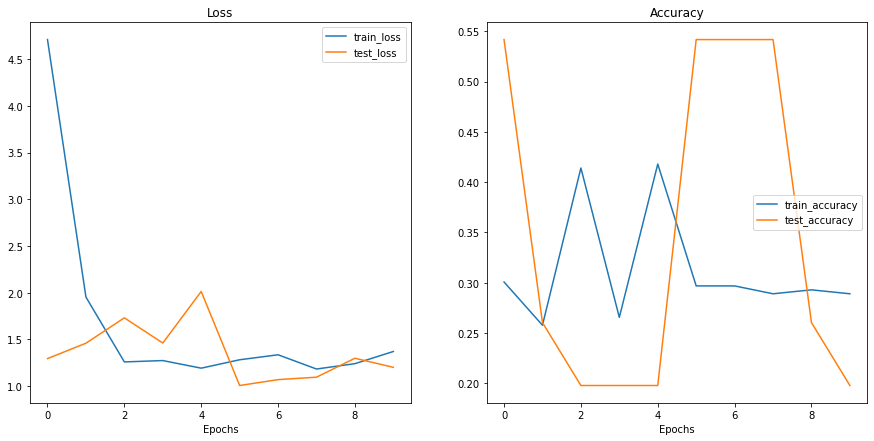

In [59]:
from services.utils import plot_loss_curves

plot_loss_curves(results=res_cutom_vit)

### Transfer learning with vision transformer

In [60]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

weights = ViT_B_16_Weights.DEFAULT
vision_transformer_b_16 = vit_b_16(weights=weights)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

In [61]:
transforms = weights.transforms()
transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [62]:
from services.data_setup import SetupData

setup_data = SetupData(train_dir=train_path,
                       test_dir=test_path,
                       train_transforms=transforms, 
                       test_transforms=transforms)

train_dataloader, test_dataloader, class_names = setup_data.create_dataloaders()

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f2ab3245c90>,
 ['pizza', 'steak', 'sushi'])

In [63]:
from torchinfo import summary

summary(model=vision_transformer_b_16,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, H, W)
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names']
       )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 1000]            768                  True
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              True
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 197, 768

In [65]:
for param in vision_transformer_b_16.parameters():
    param.requires_grad = False

In [66]:
summary(model=vision_transformer_b_16,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, H, W)
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names']
       )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 1000]            768                  False
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 197

In [67]:
vision_transformer_b_16.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [68]:
vision_transformer_b_16.heads = nn.Linear(in_features=768,
                                         out_features=3,
                                         bias=True)

In [69]:
summary(model=vision_transformer_b_16,
        input_size=(1, 3, 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names']
       )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [70]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=vision_transformer_b_16.parameters(),
                             weight_decay=0.1,
                             lr=1e-3)

In [71]:
from services.engine import TrainTestStep

epochs = 10

train_setup = TrainTestStep(model=vision_transformer_b_16,
                            train_dataloader=train_dataloader,
                            test_dataloader=test_dataloader,
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            epochs=epochs,
                            device=device)

pretrained_vit = train_setup.train_model()

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7614 | train_acc: 0.6992 | test_loss: 0.5627 | test_acc: 0.8068
Epoch: 2 | train_loss: 0.3560 | train_acc: 0.9102 | test_loss: 0.3497 | test_acc: 0.8778
Epoch: 3 | train_loss: 0.2225 | train_acc: 0.9531 | test_loss: 0.2352 | test_acc: 0.8977
Epoch: 4 | train_loss: 0.1617 | train_acc: 0.9570 | test_loss: 0.1988 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.1575 | train_acc: 0.9648 | test_loss: 0.1994 | test_acc: 0.8873
Epoch: 6 | train_loss: 0.1184 | train_acc: 0.9727 | test_loss: 0.2187 | test_acc: 0.9186
Epoch: 7 | train_loss: 0.1181 | train_acc: 0.9727 | test_loss: 0.2159 | test_acc: 0.9186
Epoch: 8 | train_loss: 0.0915 | train_acc: 0.9844 | test_loss: 0.1887 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.0861 | train_acc: 0.9844 | test_loss: 0.1779 | test_acc: 0.9176
Epoch: 10 | train_loss: 0.1299 | train_acc: 0.9883 | test_loss: 0.1871 | test_acc: 0.9176
Model took 29.77 seconds to train.


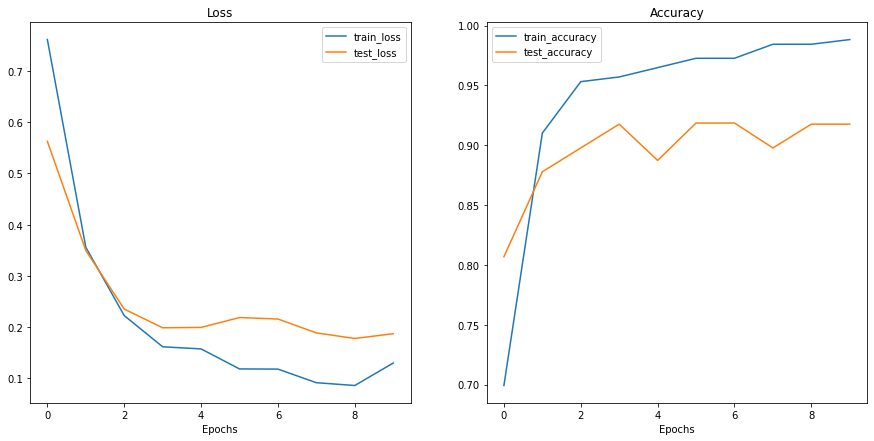

In [72]:
plot_loss_curves(pretrained_vit)

In [74]:
from pathlib import Path

pretrained_model_size = Path('models/vision_transformer_10_epochs_91_acc_test.pth').stat().st_size // (1024 * 1024)
pretrained_model_size # too big

327

In [89]:
from services.utils import pred_and_plot_image
from torchvision.models import vit_b_16

pretrained_model = vit_b_16()

In [86]:
from services.utils import save_model

save_model(model=vision_transformer_b_16,
           target_dir='models',
           model_name='vision_transformer_10_epochs_91_acc_test.pth')

[INFO] Saving model to: models/vision_transformer_10_epochs_91_acc_test.pth


In [90]:
pretrained_model.load_state_dict(torch.load('./models/vision_transformer_10_epochs_91_acc_test.pth'))

RuntimeError: ignored

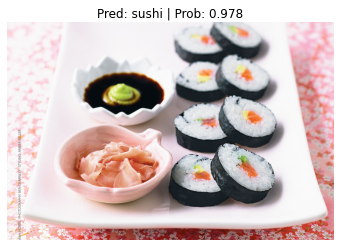

In [84]:
pred_and_plot_image(model=vision_transformer_b_16,
                    image_path='./Sushi.jpeg',
                    class_names=class_names,
                    transform=transforms,
                    device=device)